In [1]:
import sys
sys.path.append('../../')
sys.path.append('./../../tests/rcgp-issues/')


import torch as tc
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

from rcgp.rcgp import TemporalRCGP
from rcgp.kernels import Matern32Kernel

import gpflow
from gpflow.functions import Constant

from rcgp_batch.rcgp.rcgp import RCGPR
from rcgp_batch.rcgp.w import IMQ

plt.rc('font', family='serif', size=16)
plt.rcParams['text.usetex'] = True

In [2]:
def generate_data(lengthscale=0.4, magnitude=2., var_y = 0.02):
    tc.manual_seed(55)  # For reproducibility
    x = tc.linspace(0, 1, 200) 
    kernel = Matern32Kernel(lengthscale=tc.tensor(lengthscale), magnitude=tc.tensor(magnitude))

    cov_matrix, mean = kernel.forward(x.reshape(-1,1), x.reshape(-1,1)) + 1e-5 * tc.eye(len(x)), tc.zeros(x.shape)

    true_f = tc.distributions.MultivariateNormal(mean, cov_matrix).sample()
    true_f = true_f + 2*np.exp(-5*x)
    true_f = true_f - true_f.mean()

    noise = tc.distributions.Normal(0, var_y).sample(true_f.shape)
    y = true_f + noise

    return x, y, true_f

def add_outliers(y):
    tc.manual_seed(10)

    y_outliers = y.clone().detach()
    outliers_loc = [89, 91,92, 95, 98, 100, 101, 105, 107, 115]
    #outliers_loc = [75, 76, 78, 79, 80, 81, 82, 84, 90]

    noise = np.abs(tc.distributions.Normal(loc=5, scale=1.).sample((len(outliers_loc), )))
    y_outliers[outliers_loc] = noise

    """    outliers_loc2 = [23, 24, 25]
    noise2 = tc.distributions.Normal(loc=0, scale=6.).sample((len(outliers_loc2), ))
    y_outliers[outliers_loc2] = y_outliers[outliers_loc2] + noise2"""
    return y_outliers, outliers_loc

true_lengthscale, true_magnitude, true_var_y = (0.1, 2., 0.25)
Xs, Ys, true_func = generate_data(lengthscale=true_lengthscale, magnitude=true_magnitude, var_y=true_var_y)
Ys_outliers, outliers_loc = add_outliers(Ys)

In [3]:
print("Number of data pts : ", len(Ys))
print("Number of outliers : ", np.sum(~np.isclose(0, Ys - Ys_outliers)))
print("Proportion (%) : ", np.sum(~np.isclose(0, Ys - Ys_outliers)) / len(Ys))

Number of data pts :  200
Number of outliers :  10
Proportion (%) :  0.05


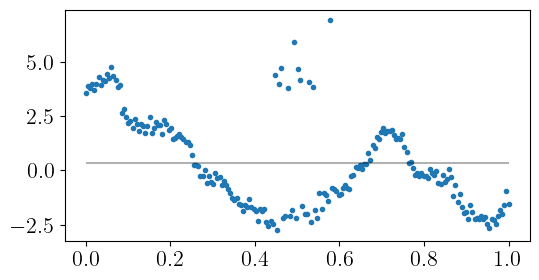

In [4]:
plt.figure(figsize=(6,3))
plt.plot(Xs, Ys_outliers, '.')
plt.hlines(Ys_outliers.mean(), 0, 1, color='black', alpha=0.3)
#plt.yscale('symlog')

# Optimization

NOTE: Results of coverage plot and efficiency are sensitive to optimization procedure (i.e., stopping earlier or later will yield over or under confident plots). For the general practictioners, this makes no difference because the fit is roughly the same (the key word here is roughly).

In [5]:
def scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor, weighted_loss : bool):
    S = covs + R
    eps = (Ys - preds).unsqueeze(-1)

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)

    if weighted_loss:
        Ws = (Ws / Ws.sum()).squeeze()
        return tc.dot(Ws, energies)
    else:
        return tc.sum(energies)
    

def coverage(preds, std, Ys):
    quantiles = np.append(np.arange(0.05, 1, 0.05), 0.9973)
    coverage_vals = []
    for confidence_level in quantiles:
        z_val = norm.ppf(1 - (1 - confidence_level)/2)
        lb = preds - z_val * std
        ub = preds + z_val * std

        is_within_bounds = (Ys >= lb) & (Ys <= ub)
        coverage_vals.append(is_within_bounds.mean())
    
    return quantiles, coverage_vals


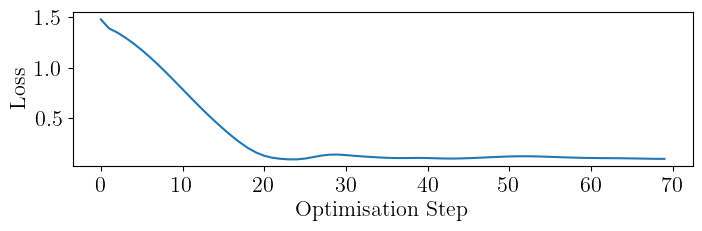

In [6]:
lr = 0.3 #Learning Rate
n_steps=70 #Number of Optimisation Steps
verbose=False #To print loss/params at each # steps
losses = [] #For plotting losses
adaptive_c, c_factor = True, 1. #If c is adaptive. If this is True c = ... below is overwritten/not used
robust, robust_func = True, "m_pred" #If robust, it's the ST-RCGP with specified robust function. If not, STGP, and c/beta are not used, and weights=1
outliers = True #If we want to fit outliers
weighted_loss=  True #If we want a weighted loss
c = 5. #If we set adaptive_c = False, this value becomes relevant. If c=None, defaults to 2 * sqrt(var_y)

if outliers:
    strcgp = TemporalRCGP(ts=Xs.reshape(-1,1), Ys=Ys_outliers.reshape(-1,1), p=1)
else:
    strcgp = TemporalRCGP(ts=Xs.reshape(-1,1), Ys=Ys.reshape(-1,1), p=1)

strcgp.c = c
if adaptive_c: strcgp.adaptive_c(c_factor=c_factor)
if robust: strcgp.activate_robustness(func=robust_func)

optimizer = tc.optim.Adam(strcgp.parameters(), lr=lr)

for step in range(n_steps):
    _,(preds, covs, R, Ws), _ = strcgp.forward()
    loss = scoring_rule(Ys=Ys.reshape(-1,1), preds=preds, covs=covs, R=R, Ws=Ws, weighted_loss=weighted_loss)
    loss.backward()
    losses.append(loss.clone().detach())
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

    if verbose and step%5==0:
        print(f"---------step {step}----------")
        print("Loss : {}".format(loss.detach().clone()))

        for name, param in strcgp.named_parameters():
            if param.requires_grad:
                print(f"{name}: {param.data}")
        print("-------------------------\n")

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

In [7]:
print("lengthscale : ", strcgp.temporal_lengthscale.item())
print("magnitude : ", strcgp.temporal_magnitude.item())
print("variance y : ", strcgp.var_y.item())

lengthscale :  0.09140012413263321
magnitude :  4.131691932678223
variance y :  0.01611151732504368


In [8]:
c = np.quantile(np.abs(Ys - Constant(Ys.mean())(Ys.reshape(-1,1))), 1 - 10/len(Ys)) 

#Train on non-outliers
model_sine = RCGPR(
    (Xs.reshape(-1,1), Ys.reshape(-1,1)),
    kernel=gpflow.kernels.SquaredExponential(),  
    weighting_function=IMQ(c),
    mean_function=Constant(Ys.mean()),
    noise_variance=0.001
)
opt = gpflow.optimizers.Scipy()
opt_options = dict()
gpflow.set_trainable(model_sine.weighting_function.C, False)

res = opt.minimize(model_sine.training_loss_closure(), model_sine.trainable_variables, options=opt_options)

#Inference on Outliers
c = np.quantile(np.abs(Ys_outliers - Constant(Ys_outliers.mean())(Ys_outliers.reshape(-1,1))), 1 - 10/len(Ys)) 

model_inference_sine = RCGPR(
    (Xs.reshape(-1,1), Ys_outliers.reshape(-1,1)),
    kernel=model_sine.kernel,  
    weighting_function=model_sine.weighting_function,
    mean_function=model_sine.mean_function,
    noise_variance=model_sine.likelihood.variance
)

f_mean_dsm_sine, f_var_dsm_sine = model_inference_sine.predict_f(Xs.reshape(-1,1), full_cov=False)
f_mean_dsm_sine = f_mean_dsm_sine.numpy().flatten()

y_pred_std_dsm_sine = np.sqrt(f_var_dsm_sine + model_inference_sine.likelihood.variance.numpy()).flatten()


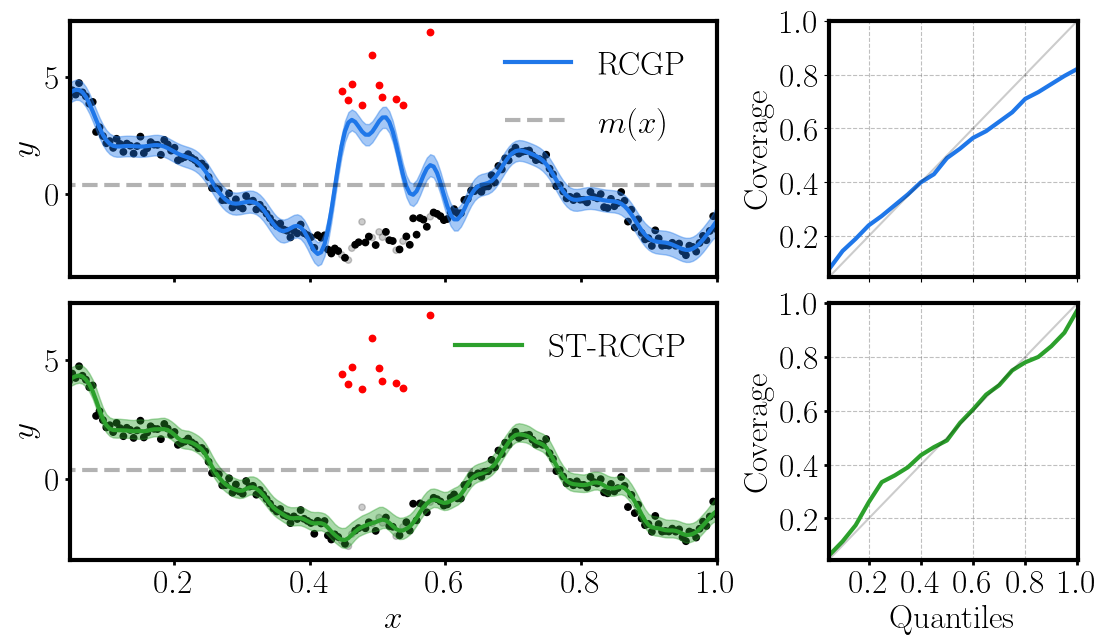

In [ ]:
plt.rc('font', family='serif', size=24)

with tc.no_grad(): 
    (pred_strcgp, std_strcgp, strcgp_eff), _, _ = strcgp.forward()
    pred_strcgp = pred_strcgp.squeeze().numpy()
    #std_strcgp = std_strcgp.squeeze().numpy()
    std_strcgp = tc.sqrt(strcgp.var_y.clone().detach() + std_strcgp**2).numpy()
    
quantiles, coverage_vals = coverage(pred_strcgp, std_strcgp, Ys.numpy())

quantiles, coverage_vals_rcgp = coverage(f_mean_dsm_sine, y_pred_std_dsm_sine, Ys.numpy())
"""
quantiles, coverage_vals = coverage(true_func.numpy(), std_strcgp, Ys.numpy())

quantiles, coverage_vals_rcgp = coverage(true_func.numpy(), y_pred_std_dsm_sine, Ys.numpy())"""

# Create a mosaic layout
fig, axs = plt.subplot_mosaic(
    [
        ["rcgp", "rcgp_quantile"],
        ["st-rcgp", "quantile"],
    ],
    figsize=(13, 7),
    sharex=True,
    gridspec_kw={"width_ratios": [2.6, 1]}
)


# Top Left Plot
if outliers:
    colors = ['black' if i not in outliers_loc else (0,0,0,0.2) for i in range(len(Xs))]

    axs['rcgp'].scatter(Xs, Ys, c=colors, s=85, marker='.')
    axs['st-rcgp'].scatter(Xs, Ys, c=colors, s=85, marker='.')

    axs['rcgp'].scatter(Xs[outliers_loc], Ys_outliers[outliers_loc], c='red', s=85, marker='.')
    axs['st-rcgp'].scatter(Xs[outliers_loc], Ys_outliers[outliers_loc], c='red', s=85, marker='.')


else:
    for idx in ['rcgp', 'st-rcgp']: axs[idx].scatter(Xs, Ys, s=85, c='black', marker='.', label="Data")


axs['st-rcgp'].plot(Xs, pred_strcgp, linewidth=3, linestyle='-', color="#2ca02c", label="ST-RCGP")
axs["st-rcgp"].hlines(Ys_outliers.mean(), 0, 1, color='black', linewidth=3, linestyles='dashed', alpha=0.3)
axs['st-rcgp'].fill_between(Xs, pred_strcgp - 1.96 * std_strcgp, pred_strcgp + 3 * std_strcgp, color="#2ca02c", alpha=0.4)

"""if outliers: 
    for idx in ['rcgp', 'st-rcgp']: axs[idx].set_yscale('symlog')
"""
axs["rcgp"].plot(Xs, f_mean_dsm_sine, linewidth=3, linestyle='-', color= "#1f77e9", label="RCGP")
axs["rcgp"].hlines(Ys_outliers.mean(), 0, 1, color='black', linewidth=3, linestyles='dashed', alpha=0.3, label=r"$m(x)$")
axs["rcgp"].fill_between(Xs, f_mean_dsm_sine - 1.96*y_pred_std_dsm_sine, f_mean_dsm_sine + 1.96*y_pred_std_dsm_sine, color="#1f77e9", alpha=0.4)


axs['st-rcgp'].set_xlim(Xs[0], Xs[-1])
axs['st-rcgp'].set_xlabel(r"$x$")

# Top Right Plot
axs["quantile"].plot(quantiles, coverage_vals, "-", color="#2ca02c", linewidth=3)
axs["rcgp_quantile"].plot(quantiles, coverage_vals_rcgp, "-", color="#1f77e9", linewidth=3)
axs["quantile"].set_xlabel("Quantiles")

for idx in ["quantile", "rcgp_quantile"]:
    axs[idx].plot(quantiles, quantiles, "k-", alpha=0.2)
    nudge = 0.003
    axs[idx].set_xlim(quantiles[0] - nudge, quantiles[-1] + nudge)
    axs[idx].set_ylim(quantiles[0] - nudge, quantiles[-1] + nudge)
    axs[idx].grid(color = 'gray', linestyle = '--', linewidth = 0.8, alpha=0.5)

    axs[idx].set_ylabel("Coverage", fontsize=24)
    axs[idx].set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
    axs[idx].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])


for spine in axs["rcgp"].spines.values():
    spine.set_linewidth(3.)

for spine in axs["st-rcgp"].spines.values():
    spine.set_linewidth(3.)

for spine in axs["quantile"].spines.values():
    spine.set_linewidth(3.)


for spine in axs["rcgp_quantile"].spines.values():
    spine.set_linewidth(3.)

axs["st-rcgp"].tick_params(width=2.)
axs["rcgp"].tick_params(width=2.)
axs["quantile"].tick_params(width=2.)


axs["st-rcgp"].set_ylabel(r"$y$")
axs["rcgp"].set_ylabel(r"$y$")


axs['rcgp'].legend(ncol=1, fontsize=24, loc="best", labelspacing=0.8, columnspacing=1, frameon=False)
axs['st-rcgp'].legend(ncol=1, fontsize=24, loc="best", frameon=False)


# Adjust layout
fig.subplots_adjust(wspace=0.25, hspace=0.1)  # Reduce spacing between subplots
#fig.savefig("./simulated-temporal-data-with-focussed-outliers.pdf", format='pdf', bbox_inches='tight')